Week_3_Assignment<br><br>
<b>[Task 1] Obtaining the Postal Code Data</b>

In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim # for converting an address into latitude and longitude values

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt

In [2]:
# obtain the data by pandas

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

dfs = pd.read_html(url)
postalcode_df = dfs[0]

In [3]:
# remove rows in which borough is not assigned.
filtered_postalcode_df = postalcode_df[postalcode_df["Borough"] != "Not assigned"]
filtered_postalcode_df.reset_index(inplace = True, drop = True)

# concatnate neighborhoods which have the shame postal code.
# Already done when I scraped the data.
if postalcode_df.shape[0] == len(postalcode_df["Postal Code"].unique()):
    print("All postal codes are unique. \n")

# put the same value as the borough column to the neighborhood column if it is not assigned
# Already done when I scraped the data.
print('Looking for rows with "Not assigned" in the Neighbourhood column.' )
print(filtered_postalcode_df[filtered_postalcode_df["Neighbourhood"] == "Not assigned"])

All postal codes are unique. 

Looking for rows with "Not assigned" in the Neighbourhood column.
Empty DataFrame
Columns: [Postal Code, Borough, Neighbourhood]
Index: []


In [4]:
filtered_postalcode_df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Now, I have finished preprocessing. Let's make clusters based on the data.<br>
My assumption is that a combination of venues makes a cluster, such that venues with many coffee shops and parks fall in a cluster. The combination becomes the characteristics of the cluster.<br><br>
<b>[Task 2] Adding the Geographical Coordinates</b>

In [5]:
# fetch the geographical coordinates
url = "http://cocl.us/Geospatial_data"
geo_df = pd.read_csv(url)

In [6]:
# merge the location data with postal codedata
filtered_postalcode_df = filtered_postalcode_df.merge(geo_df)

In [7]:
filtered_postalcode_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


<b>[Task 3] Making Clusters</b>

In [8]:
# Remove boroughs that do not have the word Toronto for simplicity

Toronto_df = filtered_postalcode_df[filtered_postalcode_df["Borough"].str.contains("Toronto")]
Toronto_df.reset_index(drop = True, inplace = True)

In [9]:
#obtain the location of Toronto
address = 'Toronto'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [15]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map to visualize the neighborhoods
for lat, lng, label in zip(Toronto_df['Latitude'], Toronto_df['Longitude'], Toronto_df['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

    
map_toronto

<b>Obtaining venues data in Tronto</b><br>
I have obained Toronto venues data in another script because it requires the secret key of my Foursquare account which should not be public.<br>
The data is saved as a csv file in the same repository. Just read it.

In [17]:
Toronto_venues = pd.read_csv("Toronto_neighborhood.csv")
Toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


Next, I convert the dataframe into one-hot data based on venues.<br>
After that, I group the data by neighborhood.

In [18]:
# convert the venue data into one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot["Neighborhood"] = Toronto_venues["Neighborhood"]
Toronto_onehot.set_index("Neighborhood", inplace = True)
Toronto_onehot.reset_index(inplace = True)

#grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.018182,0.000000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Business reply mail Processing Centre, South C...",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0625,0.0625,0.0625,0.125,0.125,0.0625,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.014706,0.000000,0.000000,0.014706,0.014706
5,Christie,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.013333,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.013333,0.000000,...,0.013333,0.013333,0.000000,0.000000,0.00,0.000000,0.000000,0.013333,0.000000,0.026667
7,"Commerce Court, Victoria Hotel",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.040000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000
8,Davisville,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.030303,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
9,Davisville North,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
# a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
# Let' sort the venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Farmers Market,Bakery,Cocktail Bar,Beer Bar,Seafood Restaurant,Cheese Shop,Restaurant,Italian Restaurant,Beach
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Nightclub,Coffee Shop,Climbing Gym,Burrito Place,Restaurant,Italian Restaurant,Intersection,Bar
2,"Business reply mail Processing Centre, South C...",Skate Park,Burrito Place,Butcher,Fast Food Restaurant,Light Rail Station,Auto Workshop,Farmers Market,Restaurant,Pizza Place,Recording Studio
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Boutique,Harbor / Marina,Sculpture Garden,Boat or Ferry,Rental Car Location,Bar,Coffee Shop,Plane
4,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Japanese Restaurant,Bubble Tea Shop,Burger Joint,Department Store,Salad Place,Thai Restaurant


<b>Run K-means</b><br>
Firstly, I ran k-means with different ks to find the best k, and obtain sum of squares for each model.<br>
Then, plot the score in a figure to find out the best k by the elbow method.

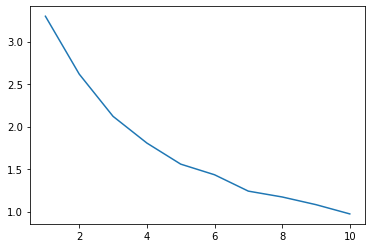

In [21]:
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
sum_of_squares = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Toronto_grouped_clustering)
    sum_of_squares.append(kmeans.inertia_)
    
# plot the sum of squares in a line chart.
plt.plot(ks, sum_of_squares)
plt.show()

In the figure above, the elbows are k = 5 and 7, meanding the best k is either 5 or 7.<br>
I choose 5 here.

In [23]:
# Run k-means with k = 5 again and obtain the labels for each neighborhood.
num_k = 5
kmeans = kmeans = KMeans(n_clusters=num_k, random_state=0).fit(Toronto_grouped_clustering)

In [24]:
## add clustering labels in the venues data frame
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# marge all the data
Toronto_merged = Toronto_df
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')
Toronto_merged.head() 

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Pub,Park,Bakery,Breakfast Spot,Theater,Café,Electronics Store,Spa,Beer Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Yoga Studio,Smoothie Shop,Beer Bar,Café,Bar,Bank,Diner,Chinese Restaurant,Italian Restaurant
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Japanese Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Bookstore,Ramen Restaurant,Italian Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Cocktail Bar,Restaurant,Gastropub,Beer Bar,American Restaurant,Lingerie Store,Seafood Restaurant,Cosmetics Shop
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Pub,Trail,Health Food Store,Yoga Studio,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant


In [25]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(num_k)
ys = [i + x + (i*x)**2 for i in range(num_k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighbourhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Most neighborhoods fall in the same cluster, which means the neighborhoods are similar regarding venues.<br>
Let's check each cluster.

<b>cluster 1</b><br>
Most neiborhoods fall in this cluster. They have coffe shops, pub and bar in common.

In [26]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Pub,Park,Bakery,Breakfast Spot,Theater,Café,Electronics Store,Spa,Beer Store
1,Downtown Toronto,0,Coffee Shop,Yoga Studio,Smoothie Shop,Beer Bar,Café,Bar,Bank,Diner,Chinese Restaurant,Italian Restaurant
2,Downtown Toronto,0,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Japanese Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Bookstore,Ramen Restaurant,Italian Restaurant
3,Downtown Toronto,0,Coffee Shop,Café,Cocktail Bar,Restaurant,Gastropub,Beer Bar,American Restaurant,Lingerie Store,Seafood Restaurant,Cosmetics Shop
4,East Toronto,0,Pub,Trail,Health Food Store,Yoga Studio,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
5,Downtown Toronto,0,Coffee Shop,Farmers Market,Bakery,Cocktail Bar,Beer Bar,Seafood Restaurant,Cheese Shop,Restaurant,Italian Restaurant,Beach
6,Downtown Toronto,0,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Japanese Restaurant,Bubble Tea Shop,Burger Joint,Department Store,Salad Place,Thai Restaurant
7,Downtown Toronto,0,Grocery Store,Café,Park,Baby Store,Coffee Shop,Athletics & Sports,Restaurant,Italian Restaurant,Nightclub,Candy Store
8,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Gym,Hotel,Clothing Store,Thai Restaurant,Bar,Office,Juice Bar
9,West Toronto,0,Pharmacy,Bakery,Grocery Store,Supermarket,Middle Eastern Restaurant,Music Venue,Café,Brewery,Bar,Bank


<b>cluster 2</b><br>
There are trails, playgronds in this area.

In [27]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,1,Trail,Playground,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


<b>cluster 3</b><br>
Bus line is the characteristics of this cluster.

In [28]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,2,Park,Bus Line,Swim School,Colombian Restaurant,Dessert Shop,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


<b>cluster 4</b><br>
Parks and trails are the characteristics.

In [29]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Central Toronto,3,Park,Sushi Restaurant,Jewelry Store,Trail,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
33,Downtown Toronto,3,Park,Trail,Playground,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


<b>cluster 5</b><br>
Music venues make this cluster unique.

In [30]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,4,Music Venue,Garden,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


<b>Conclusion</b><br>

I have made clusters from Toronto neighborhoods. Most of them are similar in respect of neighborhoods because they have coffee shops, pubs and bars in common. A few neighbors are in different clusters. They have unique characteristics. Trails and playgrounds are characteristics of the cluster 2, bus lines are for the cluster 3, parks and trails for the cluster 4, and music venues for the cluster 5. In other words, each cluster has characteristic venues.